# This notebook serves as the code and solution to the Data Analysis Interview Challenge by Springboard (Ultimate Inc Challenge).

## Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­ minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Data=pd.read_json('logins.json')

In [3]:
Data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
Data.shape

(93142, 1)

In [5]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


# The data can best be described as a list of time stamps that indicates a login. All entries are of type datetime64, and no null values are present.

In [6]:
#we check to see if the dates are sorted:

In [7]:
Deltas=[]
for i in range(len(Data)-1):
    Deltas.append(pd.Timedelta(Data.iloc[i+1,0]-Data.iloc[i,0]).total_seconds()/60)

In [8]:
np.min(Deltas)

-29.233333333333334

The data is thus not sorted. We consequently sort it. That will accelerate grouping into 15 minute intervals


In [9]:
Data_sorted=Data.sort_values('login_time')

In [10]:
Deltas=[]
for i in range(len(Data)-1):
    Deltas.append(pd.Timedelta(Data_sorted.iloc[i+1,0]-Data_sorted.iloc[i,0]).total_seconds()/60)

In [11]:
np.min(Deltas)

0.0

In [12]:
print('max delta is: {}'.format(np.max(Deltas)))
print('We expect the deltas to be in {} with 99% confidence'.format(str(np.percentile(Deltas,[0.5,99.5]))))
#this seems to be a little bit fishy..Seems like there might be some missing data for a 92 minute period

max delta is: 91.68333333333334
We expect the deltas to be in [ 0.         17.41666667] with 99% confidence


In [13]:
#so the data has been sorted.
#We now set the data as the index and use the time grouper.

In [14]:
#set the time as index
Data_sorted.set_index('login_time',drop=False, inplace=True) 

#use TimeGrouper to group the 15 minute intervals and aggregate with count
Data_grouped=Data_sorted.groupby(pd.TimeGrouper(freq='15Min')).count() 

#change index name
Data_grouped.index.name='Interval_start'

#format counts column name
Data_grouped.columns=['Count']

/home/harajlim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """


In [15]:
Data_grouped.head()

,Count
Interval_start,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [16]:
#we add a day of the week column this will be useful later
#days of the week are:
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']


DayOfTheWeek=[]
for i in range(len(Data_grouped)):
    #get day of the week based on date
    DayOfTheWeek.append(days[Data_grouped.index[i].weekday()])
    
#add day of the week column    
Data_grouped['DayOfTheWeek']=DayOfTheWeek

In [17]:
Data_grouped.head()

,Count,DayOfTheWeek
Interval_start,,
1970-01-01 20:00:00,2,Thursday
1970-01-01 20:15:00,6,Thursday
1970-01-01 20:30:00,9,Thursday
1970-01-01 20:45:00,7,Thursday
1970-01-01 21:00:00,1,Thursday


In [18]:
#we see above that the first interval starts at the first of january 1970 at 8 pm.

In [19]:
#we build a plot helper function to highlight time series at weekend days

def highlight(indices,ax):
    i=0
    while i<len(indices)-1:
        #to make sure we dont fill between a Sunday and the next Saturday
        if pd.Timedelta(indices[i+1]-indices[i]).total_seconds()/3600/24<1:
            ax.axvspan(indices[i], indices[i+1], facecolor='pink', edgecolor='none', alpha=.2)
        i+=1



Text(0,0.5,'Count')

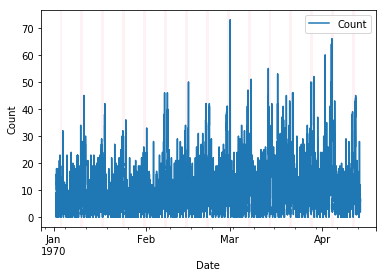

In [20]:
#we plot the login count over the entire Data:
ax=Data_grouped.plot()

#we highlight the weekends
highlight(Data_grouped[Data_grouped['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')


# Note that the highlighted parts are during the weekends. The first interesting thing we see is a spike in demand at, or right after the weekend. We cannot discuss daily patterns just yet as the above graph is too much to take in. We next look more closely at weekly cycles.

Text(0,0.5,'Count')

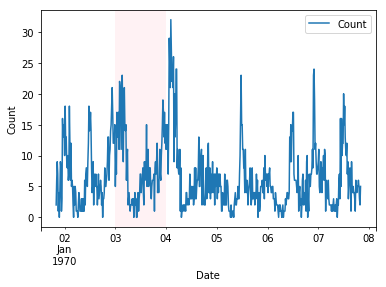

In [21]:
#We look at the first week alone
DF_toplot=Data_grouped['1970-01-01 20:00:00':'1970-01-07 20:00:00']
ax=DF_toplot.plot()

#we highlight the weekend
highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')


Text(0,0.5,'Count')

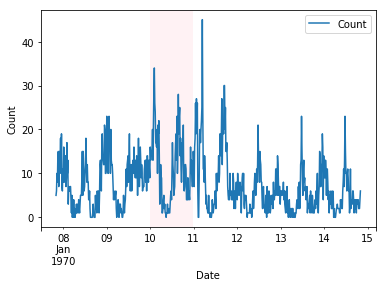

In [22]:
#We check the next week:
DF_toplot=Data_grouped['1970-01-07 20:00:00':'1970-01-14 20:00:00']
ax=DF_toplot.plot()

#we highlight the weekend
highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')


Text(0,0.5,'Count')

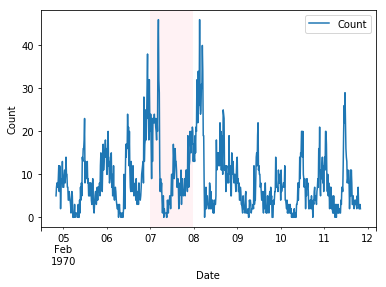

In [23]:
#we finally check a random week:
DF_toplot=Data_grouped['1970-02-04 20:00:00':'1970-02-11 20:00:00']
ax=DF_toplot.plot()

#we highlight the weekend
highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')

## From the above we can see that there is infact a surge happening right at the beggining and right after the weekend.

## We next investigate daily cycles by picking a few days and looking at their demand variations.

the plot covers the days ['Sunday', 'Monday']


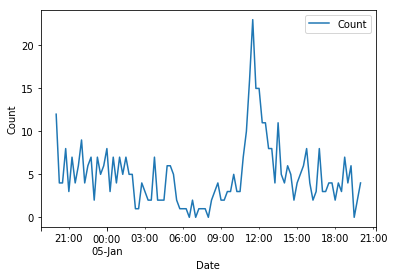

In [24]:
DF_toplot=Data_grouped['1970-01-04 20:00:00':'1970-01-05 20:00:00']

ax=DF_toplot.plot()
#highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')

print('the plot covers the days {}'.format([str(DF_toplot.DayOfTheWeek.value_counts().index[1]),str(DF_toplot.DayOfTheWeek.value_counts().index[0])]))
      

the plot covers the days ['Wednesday', 'Thursday']


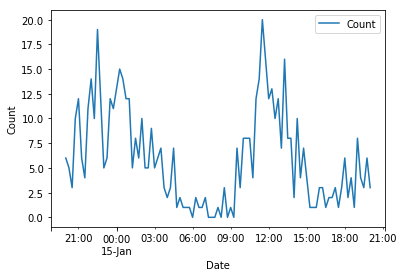

In [25]:
DF_toplot=Data_grouped['1970-01-14 20:00:00':'1970-01-15 20:00:00']

ax=DF_toplot.plot()
#highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')


print('the plot covers the days {}'.format([str(DF_toplot.DayOfTheWeek.value_counts().index[1]),str(DF_toplot.DayOfTheWeek.value_counts().index[0])]))
      

the plot covers the days ['Saturday', 'Sunday']


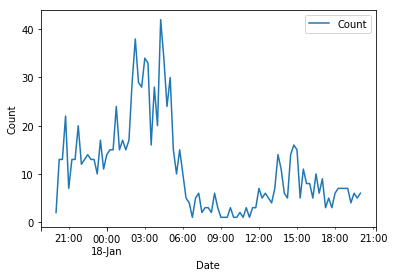

In [26]:
DF_toplot=Data_grouped['1970-01-17 20:00:00':'1970-01-18 20:00:00']

ax=DF_toplot.plot()
#highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')


print('the plot covers the days {}'.format([str(DF_toplot.DayOfTheWeek.value_counts().index[1]),str(DF_toplot.DayOfTheWeek.value_counts().index[0])]))
      

## We see a trend where week days have a cycle happening, and weekends have another. We take a  closer look by averaging over days.

In [27]:
# Next we look into grouping Date-With Day of the week, and getting average counts over each day of the week.
time=[]
for i in range(len(Data_grouped)):
    time.append(Data_grouped.index[i].time())

#we add a column including time only
Data_grouped['Time']=time


#Next We group by DayOfTheWeek and Time

In [28]:
#we next group by day of the week and time of day and aggregate with mean count and standard deviation
AverageOverDay=Data_grouped.groupby(['DayOfTheWeek','Time']).Count.agg(['mean','std'])

#we add a day of the week column, a upper bound = mean+2*std, and a lower bound(mean-2*std)
#this gives us 95% confidence intervals for the counts over all days of the week
day=[]
upperBound=[]
lowerBound=[]
for i in range(len(AverageOverDay)):
    day.append(AverageOverDay.index[i][0])
    upperBound.append(AverageOverDay['mean'][i]+2*AverageOverDay['std'][i])
    lowerBound.append(AverageOverDay['mean'][i]-2*AverageOverDay['std'][i])
    
    
AverageOverDay['Upper']=upperBound
AverageOverDay['Lower']=lowerBound
AverageOverDay['DOW']=day
AverageOverDay.head()

mean       std      Upper     Lower     DOW
DayOfTheWeek Time                                                      
Friday       00:00:00  15.800000  7.282072  30.364144  1.235856  Friday
             00:15:00  17.533333  5.139020  27.811373  7.255294  Friday
             00:30:00  15.466667  5.180550  25.827766  5.105567  Friday
             00:45:00  16.200000  5.479833  27.159666  5.240334  Friday
             01:00:00  17.266667  6.385997  30.038660  4.494673  Friday

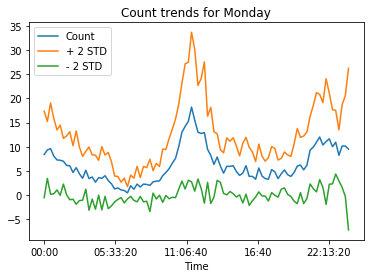

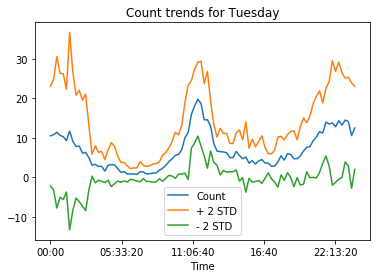

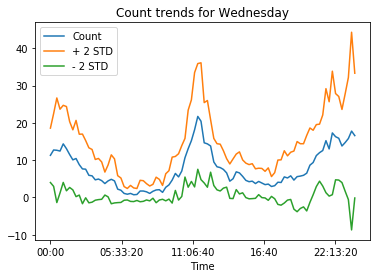

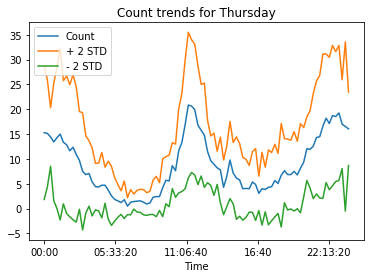

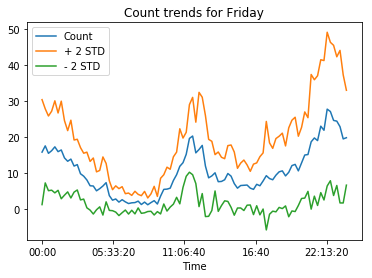

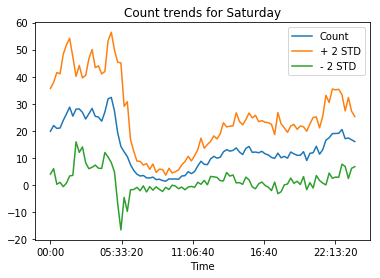

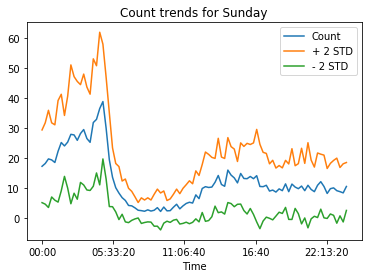

In [29]:
#plot for each day:
for day in days:
    ax=AverageOverDay[AverageOverDay['DOW']==day].unstack(level=0)['mean'].plot()
    AverageOverDay[AverageOverDay['DOW']==day].unstack(level=0)['Upper'].plot(ax=ax)
    AverageOverDay[AverageOverDay['DOW']==day].unstack(level=0)['Lower'].plot(ax=ax)
    ax.set_title('Count trends for {}'.format(day))
    ax.legend(['Count','+ 2 STD','- 2 STD'])


## Question Solution:





In the above, we loaded the json file as a pandas dataframe, sorted it, finally grouping logins into 15 minute intervals and providing the count for each interval.


We next plotted the login counts through time, first looking at the variation throughtout the entire data set, then through a select few weeks, then through select 24 hour periods. Finally, we grouped by time of day and day of the week and obtained the average over groups along with standard deviation to obtain a 95% condifence interval of counts over the hours of each day.

The main takeaways were:


1- There seems to be a surge in logins just at the beggining of the weekends and just after.


2- The are certain repetitive cycles happening over different days. Mainly: From Tuesday through Friday, the day starts (midnight) at a surge of about 10-15 logins per 15 minutes. This decreases to 1-5 logins every 15 mins at around 6 am increasing to about 20 at noon. Then decreases back to 5 at about 5 pm, finally increasing back up as it gets closer to midnight.


For Saturday and Sunday, the days maintain a surge of about 35 logins per 15 minutes intervals up till around 5 am. Then Decreasing to around 5 at 9 am, steadily increasing to about 10 at the end of the day.




## Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two ­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment

    b. what statistical test(s) you will conduct to verify the significance of the
    observation

    c. how you would interpret the results and provide recommendations to the city
    operations team along with any caveats.

# Solution:

At the moment, driver partners are exclusive to one city as to avoid toll costs.

We define trip origin as:

Trip Origin: The location of the start of a trip where the driver picked up a customer.


For a 24 hour period, a driver serving both cities can be defined as one who has trip origins in both cities. Of course, this definition can be tweaked depending on what the goal of the experiment is (we could say that a driver served both cities if the ratio of trip origins in city A to city B is close to 1). 

## Solution To Question 1: The propotion of drivers serving both cities will be the key metric used to evaluate how successfull the experiment is.

With a measure of success we now design our experiment.



## Solution to Question 2:

The experiment duration is picked. For example the 24 hour period from 12:01 am till 11:59 pm for a given Wednesday.

Let N be the total number of operational drivers Ultimate Inc has. 

Let n_test << N with n_test>50 drivers.

Inform n_test drivers that they will be eligible for the reimbursement on the given experiment day.

The remaining n_control drivers will not be offered the reimbursement. n_control can either be N-n_test or just a small pool of representative drivers Ultimate Inc has access to data for. Of course the bigger the number the better.


This way we have a control group (those who did not get the reimbursement option) and a test group (those who did), who have all the conditions similar except for the option of reimbursement.

Calling sb_control: the number of drivers in the control group that served both cities.

p_control: the proportion of drivers in the control group that served both cities=sb_control/n_control

sb_test: the number of drivers in the test group that served both cities.

p_test: the proportion of drivers in the test group that served both cities=sb_test/n_test

p=(sb_test+sb_control)/(n_test+n_control)

We set our null hypothesis H0: p_test=p_control and alternate hypothesis Ha as p_test>p_control

We set a significance Level (say 0.05).

A z statistics can then be calculated for the difference observed (assuming we get sample sizes that are representative).

The z-statistic can be computed as: (p_control-p_test)/sqrt(A)

Where A=p(1-p)((1/n_test)+(1/n_control))

If the z-statistic exceeds the allowed value under the significance level chosen, the null hypothesis is rejected, and the alternate accepted.

The significance Level would have to be discussed in detail, as it plays a major role in the interpretation of results. I would explain that a significance level is inversely proportional to how certain we want to be that the difference between the proprotions is true. 










In [30]:
##Question 3:

## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account inJanuary 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to

improve its long­ term rider retention (again, a few sentences will suffice).

In [31]:
#we begin with loading the data:
import json
with open('ultimate_data_challenge.json') as file:
    Data=json.load(file)
    
Data_DF=pd.DataFrame(Data)
Data_DF.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [32]:
Data_DF.shape
#We have the information for 50000 users.
#for each user we have 12 features.

(50000, 12)

In [33]:
Data_DF.info()
#we see that some of the features are null for some entries. 
#(e.g. only 41878 of the riders have an avg_rating_of_driver)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [34]:
#for the numerical features we get some statistics:
Data_DF.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [35]:
#next we change the time columns into type datetime.
Data_DF['last_trip_date']=pd.to_datetime(Data_DF['last_trip_date'])
Data_DF['signup_date']=pd.to_datetime(Data_DF['signup_date'])
Data_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [36]:
#We check to see if all users in this data set infact signed up in january:
print('The earliest sign up date is: {}'.format(str(Data_DF.signup_date.min().date())))
print('The latest sign up date is: {}'.format(str(Data_DF.signup_date.max().date())))

#all sign ups happen in january

The earliest sign up date is: 2014-01-01
The latest sign up date is: 2014-01-31


In [37]:
#We assume that the last day any of the riders had a ride is the day this information was obtained.
#From LastRecordingDate, we can go back 30 days to check if riders have been retained.
LastRecordingDate=Data_DF.last_trip_date.max()
print('Last recording date is {}'.format(LastRecordingDate.date()))

Last recording date is 2014-07-01


In [38]:
#we now add a column indicating if each user entry was active within 30 days of the last recording date
retained=[]
for i in range(len(Data_DF)):
    #we check if the user was active within 30 days from the day this data set was obtained
    if pd.Timedelta(LastRecordingDate-Data_DF['last_trip_date'][i]).days<30:
        retained.append(1)
    else:
        retained.append(0)

#we add a column indicating if retained (1) or not (0)
Data_DF['retained']=retained

In [39]:
Data_DF.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084,0.36620
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503,0.48177
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000,0.00000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,0.00000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000,1.00000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.00000


In [40]:
#as can be seen 36.6% of people who signed up on january first were retained.

## Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

We begin by picking the features we wish to use:

signup date is dropped as a feature, as well as last trip date.

We fill missing values by adding the mean of the feature.



In [41]:
Data_new=Data_DF.fillna(Data_DF.mean())
Data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


In [42]:
#To fill the phone columns, we replace missing data with the most frequent phone.

Data_new = Data_new.fillna(Data_new['phone'].value_counts().index[0])

In [43]:
Data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


In [44]:
Data_new.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


The data now has no missing entries. We can thus fit a model of our chosing. For this exercise we chose to go with a logistic regression. THis is done to get a little bit of interpretability from the model. Namely, we would like to get an idea of what an increase in a numerical value mean in terms of the probability of the driver being retained. 

For the categorical data, we one-hot encode.

In [45]:
#one Hot-Encode the city column
col='city'
Data_new = pd.concat([Data_new,pd.get_dummies(Data_new[col], prefix=col,dummy_na=False)],axis=1).\
drop([col],axis=1)

In [46]:
#one Hot-Encode the phone column
col='phone'
Data_new = pd.concat([Data_new,pd.get_dummies(Data_new[col], prefix=col,dummy_na=False)],axis=1).\
drop([col],axis=1)

In [47]:
Data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
city_Astapor              50000 non-null uint8
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_Android             50000 non-null uint8
phone_iPhone              50000 non-null uint8
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), uint8(5)
memory usage: 4.1 MB


In [48]:
#we finally just change the ultimate_black_user to type int.

Data_new['ultimate_black_user']=Data_new['ultimate_black_user'].astype('int')

In [49]:
Data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
city_Astapor              50000 non-null uint8
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_Android             50000 non-null uint8
phone_iPhone              50000 non-null uint8
dtypes: datetime64[ns](2), float64(6), int64(3), uint8(5)
memory usage: 4.4 MB


In [50]:
Data_new.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,0.37708,60.926084,0.36620,0.330680,0.202600,0.466720,0.300440,0.699560
std,5.707357,0.445753,0.564977,0.222336,19.958811,3.792684,0.48466,37.081503,0.48177,0.470463,0.401941,0.498896,0.458454,0.458454
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,0.00000,33.300000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,0.00000,66.700000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,1.00000,100.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,1.00000,100.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
#we obtain the predicitve features
X=Data_new.drop(['last_trip_date','signup_date','retained'],axis=1)
#and their corresponding labels
Y=Data_new[['retained']]

#we then split the data into training and testing data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)
#we now fit a logist Regression model
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression(C=0.01)

lr.fit(X_train,y_train)

print('The models accuracy on training data is: {}'.format(lr.score(X_train,y_train)))
print('The models accuracy on testing data is: {}'.format(lr.score(X_test,y_test)))

from sklearn.metrics import confusion_matrix,f1_score
print('Confusion Matrix for Testing Data')
print(confusion_matrix(y_test,lr.predict(X_test)))

print('F1 score on testing Data:')
print(f1_score(y_test,lr.predict(X_test)))


/home/harajlim/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The models accuracy on training data is: 0.72435
The models accuracy on testing data is: 0.7276
Confusion Matrix for Testing Data
[[5512  807]
 [1917 1764]]
F1 score on testing Data:
0.5642994241842609


In [52]:
for i in range(len(X.columns)):
    print('Coefficient for {0} is {1}'.format(X.columns[i],lr.coef_[0,i]))

Coefficient for avg_dist is -0.03563854007503784
Coefficient for avg_rating_by_driver is -0.15143546868654212
Coefficient for avg_rating_of_driver is -0.056882902237577984
Coefficient for avg_surge is -0.1461535571583246
Coefficient for surge_pct is 0.0038457286391981155
Coefficient for trips_in_first_30_days is 0.12228758535208202
Coefficient for ultimate_black_user is 0.835995857647154
Coefficient for weekday_pct is 0.0009435664903419535
Coefficient for city_Astapor is -0.7285198482659107
Coefficient for city_King's Landing is 0.9175771828203393
Coefficient for city_Winterfell is -0.22131652296407492
Coefficient for phone_Android is -0.5603235923716927
Coefficient for phone_iPhone is 0.5280644039616839


In [53]:
#we now try a random forest model
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(n_estimators=800)

RF.fit(X_train,y_train)

print('The models accuracy on training data is: {}'.format(RF.score(X_train,y_train)))
print('The models accuracy on training data is: {}'.format(RF.score(X_test,y_test)))


print('Confusion Matrix')
print(confusion_matrix(y_test,RF.predict(X_test)))

print('F1 score is:')
print(f1_score(y_test,RF.predict(X_test)))

/home/harajlim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


The models accuracy on training data is: 0.99685
The models accuracy on training data is: 0.7623
Confusion Matrix
[[5181 1138]
 [1239 2442]]
F1 score is:
0.6726346233301198


We note some lack of rigor in our approach above:

1-We did not perform any hyper-parameter tuning.

2-We checked for validity of the model by testing on a held out test set. A better approach would be to do a cross validation (or even nested cross validation if we were interested in hyper parameter tunining being part of the validation).

In terms of performance, the Random Forest performed better with an F1 score of 0.67 as compared to 0.56 for the logistic regression. Accuracy scores for the Random forest were higher with a value of 76.23%. We note that a baseline model predicting retention as 0 would have given an accuracy of 100-36.6=63.4%. So we are doing better than that.

While the Random Forest gives better predictive power, the logistic regression provides some interpretability. Specifically, the sign of the coefficient of each feature tells how how the log of the odds ratio changes with a unit change in the feature. 

The logistic Regression can also help point things that negatively effect rider retain rate. Namely, it seems like android phone users are less likely to be retained (coefficient of -0.56). This could be due to the app on the android not being as good as that on the iphone (which has a coefficient of 0.528). 

This can be used by Ultimate Inc to understand what is effecting rider retention rates, and address these issues.
